<a href="https://colab.research.google.com/github/nishanthnandakumar/Lidar_Radar_Systems/blob/main/lidarradarassignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # load point clouds and more array/vector operations
import cv2 # load images
import plotly.graph_objects as go # visualize point clouds

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
root = "./gdrive/MyDrive/dataset/Record1/"

In [4]:
ind = 19
blick = np.loadtxt(root + "Blickfeld/point_cloud/%06d.csv" % ind)
bb = np.loadtxt(root + "/Blickfeld/bounding_box/%06d.csv" % ind)

In [5]:
print(blick[0])

[-1.13817635e+01  1.57566442e+01 -4.38803341e-03  1.62919843e+09]


In [6]:
print(bb)

[ 1.18781636  6.10341683 -0.40062054  1.94        4.304       1.459
  0.        ]


In [7]:
def rt_matrix(x=0, y=0, z=0, roll=0, pitch=0, yaw=0):
    """
        Calculates a 4x4 Transformation Matrix. Angels in radian!
    """
    c_y = np.cos(yaw)
    s_y = np.sin(yaw)
    c_r = np.cos(roll)
    s_r = np.sin(roll)
    c_p = np.cos(pitch)
    s_p = np.sin(pitch)
    
    rot = np.dot(np.dot(np.array([[c_y,-s_y,0],
                                     [s_y,c_y,0],
                                     [0,0,1]]),
                           np.array([[c_p,0,s_p],
                                     [0,1,0],
                                     [-s_p,0,c_p]])),
                            np.array([[1,0,0],
                                     [0,c_r,-s_r],
                                     [0,s_r,c_r]]))
    matrix = np.array([[0,0,0,x],
                     [0,0,0,y],
                     [0,0,0,z],
                     [0,0,0,1.]])
    matrix[0:3,0:3] += rot
    return matrix

In [8]:
#Calculate the 8 corners of the bounding box
def transfer_points(points, rot_t):
    """
        Calculates the transformation of a point cloud for a given transformation matrix.
    """
    points = np.concatenate([points, np.ones([1,points.shape[1]])])
    points[0:3,:] = np.dot(rot_t, points[0:4,:])[0:3, :]
    return points[0:3]

    

In [9]:
def make_boundingbox(label):
    """
        Calculates the Corners of a bounding box from the parameters.
    """
    corner = np.array([
        [+ label[3]/2, + label[4]/2, + label[5]/2],
        [+ label[3]/2, + label[4]/2, - label[5]/2],
        [+ label[3]/2, - label[4]/2, + label[5]/2],
        [+ label[3]/2, - label[4]/2, - label[5]/2],
        [- label[3]/2, + label[4]/2, + label[5]/2],
        [- label[3]/2, - label[4]/2, + label[5]/2],
        [- label[3]/2, + label[4]/2, - label[5]/2],
        [- label[3]/2, - label[4]/2, - label[5]/2],
    ])
    corner = transfer_points(corner.T, rt_matrix(yaw = label[6])).T
    corner = corner + label[0:3]
    return corner

In [10]:
bb = make_boundingbox(bb)

In [11]:
bb

array([[ 2.15781636,  8.25541683,  0.32887946],
       [ 2.15781636,  8.25541683, -1.13012054],
       [ 2.15781636,  3.95141683,  0.32887946],
       [ 2.15781636,  3.95141683, -1.13012054],
       [ 0.21781636,  8.25541683,  0.32887946],
       [ 0.21781636,  3.95141683,  0.32887946],
       [ 0.21781636,  8.25541683, -1.13012054],
       [ 0.21781636,  3.95141683, -1.13012054]])

In [12]:
def minmaxbb(bounding_box):
  #Here we max and min for bounding box
  #Initialize the variables with some maximum and minimum values
  x_max = -10000
  x_min = 10000
  y_max = -10000
  y_min = 10000
  z_max = -10000
  z_min = 10000
  for corner in bounding_box:
    if corner[0] >= x_max:
      x_max = corner[0]
    if corner[0] <= x_min:
      x_min = corner[0]

    if corner[1] >= y_max:
      y_max = corner[1]
    if corner[1] <= y_min:
      y_min = corner[1]

    if corner[2] >= z_max:
      z_max = corner[2]
    if corner[2] <= z_min:
      z_min = corner[2]


  return x_max,x_min,y_max,y_min,z_max,z_min



In [13]:
x_max,x_min,y_max,y_min,z_max,z_min = minmaxbb(bb)

In [14]:
y_min

3.951416832509941

In [15]:
y_max

8.25541683250994

In [16]:
def separatepoints(data, bounding_box):
  #Here we separate the points from the data
  car = []

  x_max,x_min,y_max,y_min,z_max,z_min = minmaxbb(bounding_box)
  for point in data:
    if (point[0] >= x_min) and (point[0] <= x_max) and (point[1] >= y_min) and (point[1] <= y_max) and (point[2] >= z_min) and (point[2] <= z_max):
      car.append(point)


  return car

In [17]:
car = separatepoints(blick, bb)

In [18]:
newcar = np.array(car)

In [19]:
newcar.shape

(3980, 4)

In [20]:
data = [go.Scatter3d(x = blick[:,0],
                     y = blick[:,1],
                     z = blick[:,2],
                    mode='markers', type='scatter3d',
                    text=np.arange(blick.shape[0]),
                    marker={
                        'size': 2,
                        'color': "blue",
                        'colorscale':'rainbow',
}),
        
        go.Scatter3d(x = bb[:,0],
                     y = bb[:,1],
                     z = bb[:,2],
                     text=np.arange(8),
                    mode='markers', type='scatter3d',
                    marker={
                        'size': 2,
                        'color': "red",
                        'colorscale':'rainbow',
}),
        
        go.Scatter3d(x = newcar[:,0],
                     y = newcar[:,1],
                     z = newcar[:,2],
                     text=np.arange(8),
                    mode='markers', type='scatter3d',
                    marker={
                        'size': 2,
                        'color': "green",
                        'colorscale':'rainbow',
})
]
layout = go.Layout(
    scene={
        'xaxis': {'range': [-25, 25], 'rangemode': 'tozero', 'tick0': -5},
        'yaxis': {'range': [-25, 25], 'rangemode': 'tozero', 'tick0': -5},
        'zaxis': {'range': [-25, 25], 'rangemode': 'tozero'}
    }
)
go.Figure(data=data, layout = layout)

In [ ]:
len(blick)

24189

In [ ]:
import matplotlib.pyplot as plt
x_blick=[22.9543764309491,22.9570349823011,22.5012551716386,21.7455536453953,21.270453505199,20.5423732186982,19.0680643480842,17.7210910750322,15.0602198317857,13.6620690775123,12.4509730290397,11.4501153365486,10.6380385814723,9.28991040492287,8.58205412706137,7.62403700713181,6.01284929759067,4.93885839891003,4.35432177374179,3.95141683250994,3.8733324989044,3.97194048832752,4.06209980112822,4.30468785384084,5.04856968446436,5.67612759188763,6.48863780782039,8.14362021544703,9.11158942592358,10.4222968202092,11.3473878700148,12.359145494791,13.827028733349,14.9210720778215,16.5014154833469,17.6414078743397,18.6526607770679,20.1734856947955,21.0626962869513,22.3491488880853,23.1368615060287,23.2124848846603]
y_blick=[106,103,113,125,131,136,159,184,264,342,396,488,554,748,864,1068,1855,2695,3475,3980,3942,3917,3793,3452,2659,2087,1535,964,783,593,497,408,323,265,221,193,162,137,126,109,102,98]
x_velo=[19.902592529988,19.896501197826,19.5212349189186,18.8216961426072,18.4359827064122,17.7750369858363,16.6310681378944,15.3857156197258,13.1791305343161,12.0171878439653,10.9989283068268,10.1715369600592,9.50072893938944,8.42562885498551,7.81591392073843,7.06772284799582,5.72052447261801,4.8139794178413,4.35302916198751,3.9956596797674,3.94369605737884,4.03129170614795,4.11034873500904,4.29386939012396,4.936966318623,5.45869106669341,6.10912513428446,7.4643046646764,8.27379223241254,9.32103292307886,10.0968928163866,10.94361376342,12.1153783147718,13.0061844325019,14.2852597485028,15.2235499411063,15.9989697805613,17.2688802893779,17.9758365493693,19.0543705763844,19.6940134775448,19.8366630590514]
y_velo=[1,0,0,4,5,0,0,0,19,17,19,27,13,29,58,65,92,174,221,247,252,247,226,187,127,96,89,54,41,19,22,20,18,7,0,0,0,0,2,2,1,1]

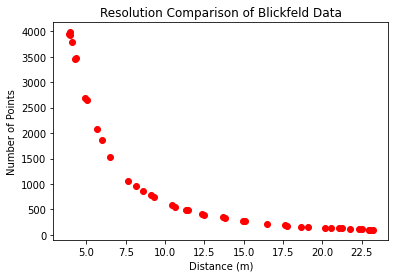

In [ ]:
plt.plot(x_blick,y_blick,'ro')
plt.title('Resolution Comparison of Blickfeld Data')
plt.xlabel('Distance (m)')
plt.ylabel('Number of Points')
plt.show()

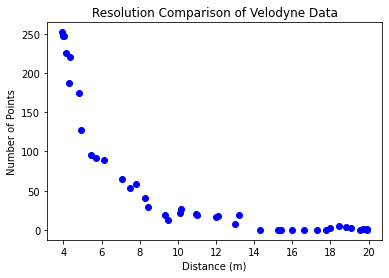

In [ ]:
plt.plot(x_velo,y_velo,'bo')
plt.title('Resolution Comparison of Velodyne Data')
plt.xlabel('Distance (m)')
plt.ylabel('Number of Points')
plt.show()

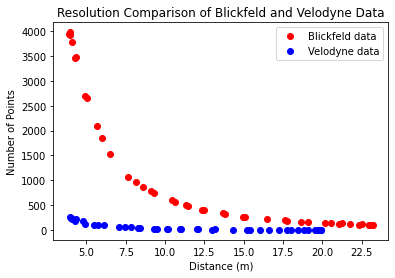

In [ ]:
line1 = plt.plot(x_blick,y_blick,'ro', label='Blickfeld data')
line2 = plt.plot(x_velo,y_velo,'bo',label='Velodyne data')
plt.title('Resolution Comparison of Blickfeld and Velodyne Data')
plt.xlabel('Distance (m)')
plt.ylabel('Number of Points')
plt.legend()
plt.show()

In [ ]:
from scipy.integrate import simps
from numpy import trapz

# Compute the area using the composite trapezoidal rule.
area = trapz(y_blick, dx=42)
print("area =", area)

area = 1850100.0


In [ ]:
from scipy.integrate import simps
from numpy import trapz

#https://stackoverflow.com/questions/13320262/calculating-the-area-under-a-curve-given-a-set-of-coordinates-without-knowing-t
# Compute the area using the composite trapezoidal rule.
area = trapz(y_velo, dx=42)
print("area =", area)

area = 100842.0


In [ ]:
# Compute the area using the composite Simpson's rule.
area = simps(y_blick, dx=42)
print("area =", area)

area = 1850103.5


In [ ]:
# Compute the area using the composite Simpson's rule.
area = simps(y_velo, dx=42)
print("area =", area)

area = 100838.5
